In [ ]:
!pip install transformers datasets scikit-learn --quiet

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

fake = pd.read_csv("/content/Fake.csv")[['title', 'text']]
true = pd.read_csv("/content/True.csv")[['title', 'text']]

fake['label'] = 0
true['label'] = 1

data = pd.concat([fake, true]).sample(frac=1).reset_index(drop=True)
data['content'] = data['title'] + " " + data['text']
data = data[['content', 'label']]

# Reduce to smallest sample (500 examples for speed)
data = data.sample(500, random_state=42)

train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['content'], data['label'], test_size=0.2, random_state=42
)

In [ ]:
from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=256)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=256)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
import torch

class FakeNewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        return {
            key: torch.tensor(val[idx]) for key, val in self.encodings.items()
        } | {'labels': torch.tensor(self.labels[idx])}
    def __len__(self):
        return len(self.labels)

train_dataset = FakeNewsDataset(train_encodings, list(train_labels))
test_dataset = FakeNewsDataset(test_encodings, list(test_labels))

In [ ]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir=None,
    logging_steps=1000,
    report_to=[],
    # evaluation_strategy="epoch",
    save_strategy="no"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer.train()

Step,Training Loss


TrainOutput(global_step=50, training_loss=0.27092857360839845, metrics={'train_runtime': 10.2353, 'train_samples_per_second': 39.08, 'train_steps_per_second': 4.885, 'total_flos': 26493479731200.0, 'train_loss': 0.27092857360839845, 'epoch': 1.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.030208425596356392,
 'eval_runtime': 0.6739,
 'eval_samples_per_second': 148.396,
 'eval_steps_per_second': 19.291,
 'epoch': 1.0}

📊 Classification Report:

              precision    recall  f1-score   support

           0      1.000     1.000     1.000        53
           1      1.000     1.000     1.000        47

    accuracy                          1.000       100
   macro avg      1.000     1.000     1.000       100
weighted avg      1.000     1.000     1.000       100



<Figure size 600x400 with 0 Axes>

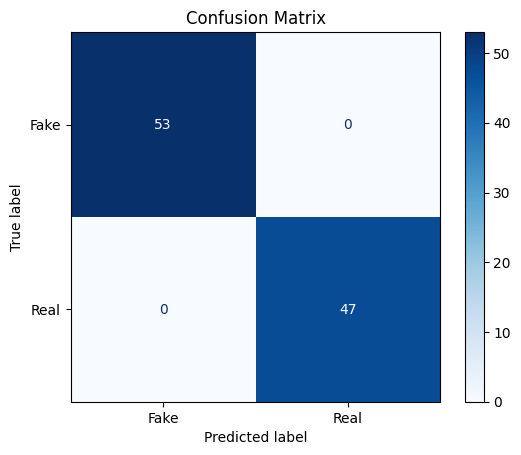

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Get predictions
preds_output = trainer.predict(test_dataset)
pred_labels = np.argmax(preds_output.predictions, axis=1)

# Metrics
print("📊 Classification Report:\n")
print(classification_report(test_labels, pred_labels, digits=3))

# Confusion Matrix
cm = confusion_matrix(test_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake', 'Real'])

plt.figure(figsize=(6, 4))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

In [ ]:
def predict_news(texts):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    encodings = tokenizer(
        texts,
        truncation=True,
        padding=True,
        max_length=256,
        return_tensors="pt"
    ).to(device)  # ✅ Move inputs to GPU

    with torch.no_grad():
        outputs = model(**encodings)
        preds = torch.argmax(outputs.logits, axis=1)

    for i, text in enumerate(texts):
        label = 'REAL' if preds[i] == 1 else 'FAKE'
        print(f"📰 Text: {text[:100]}...\n📌 Prediction: {label}\n")

In [ ]:
sample_news = [
    "The government has announced new measures to fight climate change this year.",
    "Scientists discover aliens living under the Earth's core, says unverified report.",
    "Apple launches a new foldable iPhone, confirmed by official sources.",
    "A celebrity claimed water cures cancer without any scientific evidence.",
    "A Fargo, North Dakota, man was arrested for clearing snow with a flamethrower.",
    "Share a certain post of Bill Gates on Facebook and he will send you money.",
  "Hey Facebook, As some of you may know, I'm Bill Gates. If you click that share link, I will give you $5,000. I always deliver, I mean, I brought you Windows XP, right?"
]

predict_news(sample_news)

📰 Text: The government has announced new measures to fight climate change this year....
📌 Prediction: REAL

📰 Text: Scientists discover aliens living under the Earth's core, says unverified report....
📌 Prediction: FAKE

📰 Text: Apple launches a new foldable iPhone, confirmed by official sources....
📌 Prediction: REAL

📰 Text: A celebrity claimed water cures cancer without any scientific evidence....
📌 Prediction: FAKE

📰 Text: A Fargo, North Dakota, man was arrested for clearing snow with a flamethrower....
📌 Prediction: FAKE

📰 Text: Share a certain post of Bill Gates on Facebook and he will send you money....
📌 Prediction: FAKE

📰 Text: Hey Facebook, As some of you may know, I'm Bill Gates. If you click that share link, I will give you...
📌 Prediction: FAKE



In [ ]:
model.save_pretrained("./fake-news-model")
tokenizer.save_pretrained("./fake-news-model")

('./fake-news-model/tokenizer_config.json',
 './fake-news-model/special_tokens_map.json',
 './fake-news-model/vocab.txt',
 './fake-news-model/added_tokens.json',
 './fake-news-model/tokenizer.json')

In [ ]:
from sklearn.metrics import classification_report

def evaluate_model(model, dataloader):
    model.eval()
    preds, labels = [], []

    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        label = batch['labels'].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            pred = torch.argmax(outputs.logits, axis=1)

        preds.extend(pred.cpu().numpy())
        labels.extend(label.cpu().numpy())

    print(classification_report(labels, preds, target_names=["FAKE", "REAL"]))

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(labels, preds):
    cm = confusion_matrix(labels, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["FAKE", "REAL"],
                yticklabels=["FAKE", "REAL"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the data
fake_df = pd.read_csv("/content/Fake.csv")
true_df = pd.read_csv("/content/True.csv")

# Label the data: fake = 0, true = 1
fake_df["label"] = 0
true_df["label"] = 1

# Combine the datasets
df = pd.concat([fake_df, true_df], ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)  # Shuffle

In [ ]:
train_val_df, test_df = train_test_split(df, test_size=0.1, stratify=df['label'], random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.1, stratify=train_val_df['label'], random_state=42)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

class FakeNewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt',
            return_attention_mask=True
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Now prepare the test_dataloader
test_dataset = FakeNewsDataset(
    texts=test_df['text'].tolist(),
    labels=test_df['label'].tolist(),
    tokenizer=tokenizer,
    max_len=128
)

test_dataloader = DataLoader(test_dataset, batch_size=16)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
def get_preds_and_labels(model, dataloader):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

In [ ]:
preds, labels = get_preds_and_labels(model, test_dataloader)

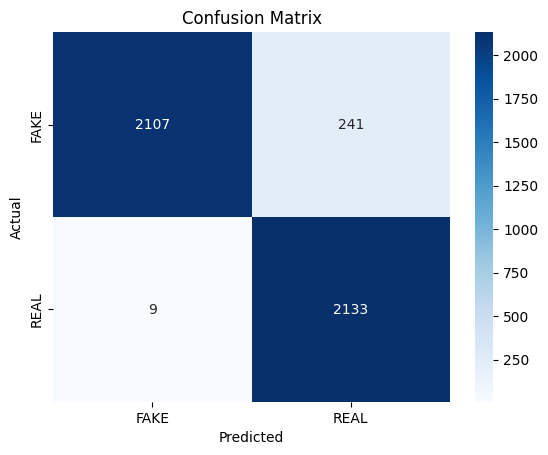

In [ ]:
plot_confusion_matrix(labels, preds)